#  Implementation-of-PCA-with-ANN-algorithm-for-Face-recognition
A face recognition project using PCA for feature extraction and ANN for classification.


##  Imports & Setup
Import all required libraries and set the dataset path, image size, and basic settings for the face recognition project.


In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings("ignore")

# ---------- EDIT THIS PATH if needed ---------
DATASET_DIR = r"D:/Jupyter Data Test/Implementation-of-PCA-with-ANN-algorithm-for-Face-recognition(dataset)/faces"
H = W = 128   
print("Dataset dir:", DATASET_DIR)


Dataset dir: D:/Jupyter Data Test/Implementation-of-PCA-with-ANN-algorithm-for-Face-recognition(dataset)/faces


##  Load Face Dataset  
Define a function to load all face images from the dataset folder, convert them to grayscale, resize them, and flatten each image into a vector.  
This prepares the data (`X`, `y_labels`, and `class_names`) for further processing.


In [2]:
def load_faces(dataset_dir, image_size=(H, W), max_per_class=None, verbose=True):
    X = []
    y = []
    class_names = []
    total_skipped = 0
    for person in sorted(os.listdir(dataset_dir)):
        person_dir = os.path.join(dataset_dir, person)
        if not os.path.isdir(person_dir):
            continue
        class_names.append(person)
        imgs = [f for f in os.listdir(person_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
        if max_per_class:
            imgs = imgs[:max_per_class]
        for imname in imgs:
            p = os.path.join(person_dir, imname)
            img = cv2.imread(p)
            if img is None:
                total_skipped += 1
                if verbose:
                    print(" Warning: could not read:", p)
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, image_size)
            X.append(resized.flatten())
            y.append(person)
    X = np.array(X)
    y = np.array(y)
    if verbose:
        print(f"Loaded {X.shape[0]} images from {len(class_names)} classes. Skipped {total_skipped} files.")
    return X, y, class_names

# load
X, y_labels, class_names = load_faces(DATASET_DIR, image_size=(H,W))
if X.size == 0:
    raise RuntimeError("No images loaded. Check DATASET_DIR and file extensions.")
print("X shape:", X.shape)
print("y shape:", y_labels.shape)


Loaded 450 images from 9 classes. Skipped 0 files.
X shape: (450, 16384)
y shape: (450,)


##  Encode Labels & Split Data  
Convert string labels into numeric form using `LabelEncoder`, then split the dataset into training and testing sets (80%–20%) while keeping class distribution balanced.


In [4]:
le = LabelEncoder()
y = le.fit_transform(y_labels)
class_names = list(le.classes_)
n_classes = len(class_names)
print("Classes:", class_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Classes: [np.str_('Aamir'), np.str_('Ajay'), np.str_('Akshay'), np.str_('Alia'), np.str_('Amitabh'), np.str_('Deepika'), np.str_('Disha'), np.str_('Farhan'), np.str_('Ileana')]
Train shape: (360, 16384) Test shape: (90, 16384)


##  Apply PCA (Eigenfaces Extraction)  
Standardize the data and apply **PCA** to extract the most significant features (eigenfaces).  
Then, visualize the top 12 eigenfaces that represent the main variations in facial features.


Extracting the top 150 eigenfaces from 360 faces


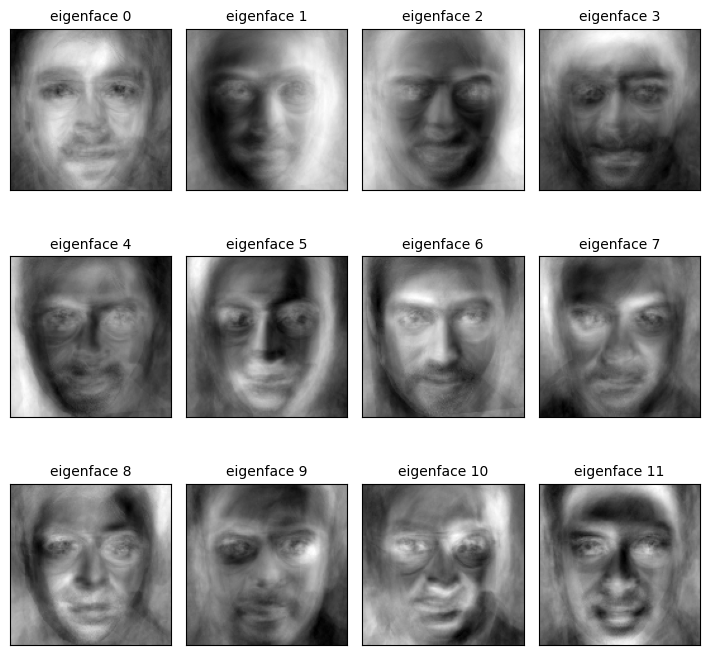

Project done... shapes: (360, 150) (90, 150)


In [5]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# PCA - choose number of eigenfaces (e.g., 150 or keep variance)
n_eigenfaces = 150
n_eigenfaces = min(n_eigenfaces, X_train_s.shape[0], X_train_s.shape[1])
pca = PCA(n_components=n_eigenfaces, svd_solver='randomized', whiten=True, random_state=42)
X_train_p = pca.fit_transform(X_train_s)
X_test_p = pca.transform(X_test_s)

print("Extracting the top", pca.n_components_, "eigenfaces from", X_train_s.shape[0], "faces")
# Visualize first 12 eigenfaces (reshape)
eigenfaces = pca.components_.reshape((pca.n_components_, H, W))

# plot eigenfaces (first 12)
ef_titles = [f"eigenface {i}" for i in range(min(12, eigenfaces.shape[0]))]
plot_gallery(eigenfaces[:12], ef_titles, H, W)
print("Project done... shapes:", X_train_p.shape, X_test_p.shape)


##  LDA + MLP Training  
Apply LDA for better class separation, train the MLP model, check accuracy, and save all trained files.


In [6]:
use_lda = True

if use_lda and n_classes >= 2:
    lda_n = min(n_classes - 1, X_train_p.shape[1])
    lda = LDA(n_components=lda_n)
    X_train_lda = lda.fit_transform(X_train_p, y_train)
    X_test_lda = lda.transform(X_test_p)
    print("LDA applied. New shape:", X_train_lda.shape)
else:
    X_train_lda = X_train_p
    X_test_lda = X_test_p
    print("Skipping LDA. Using PCA features. Shape:", X_train_lda.shape)

# Train MLP classifier
clf = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=42, verbose=True)
clf.fit(X_train_lda, y_train)

# Evaluate
y_pred = clf.predict(X_test_lda)
acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)
print(classification_report(y_test, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Save artifacts
os.makedirs("artifacts", exist_ok=True)
joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(pca, "artifacts/pca.joblib")
joblib.dump(clf, "artifacts/mlp_classifier.joblib")
joblib.dump(le, "artifacts/label_encoder.joblib")
if use_lda and n_classes >= 2:
    joblib.dump(lda, "artifacts/lda.joblib")
print("Saved artifacts to ./artifacts")


LDA applied. New shape: (360, 8)
Iteration 1, loss = 2.25951091
Iteration 2, loss = 2.01938508
Iteration 3, loss = 1.80610327
Iteration 4, loss = 1.61043150
Iteration 5, loss = 1.43249239
Iteration 6, loss = 1.26900113
Iteration 7, loss = 1.11820322
Iteration 8, loss = 0.98628586
Iteration 9, loss = 0.86548342
Iteration 10, loss = 0.75726432
Iteration 11, loss = 0.66072421
Iteration 12, loss = 0.57419414
Iteration 13, loss = 0.49808171
Iteration 14, loss = 0.43119650
Iteration 15, loss = 0.37459062
Iteration 16, loss = 0.32524079
Iteration 17, loss = 0.28365376
Iteration 18, loss = 0.24940594
Iteration 19, loss = 0.22055749
Iteration 20, loss = 0.19601417
Iteration 21, loss = 0.17552391
Iteration 22, loss = 0.15838830
Iteration 23, loss = 0.14431988
Iteration 24, loss = 0.13168656
Iteration 25, loss = 0.12128739
Iteration 26, loss = 0.11219263
Iteration 27, loss = 0.10446098
Iteration 28, loss = 0.09782045
Iteration 29, loss = 0.09170241
Iteration 30, loss = 0.08637097
Iteration 31, lo

##  Model Predictions and Visualization  
Predict the test images using the trained MLP model.  
Display the top predictions with confidence scores and true labels — showing **clear face images** similar to the sample project.


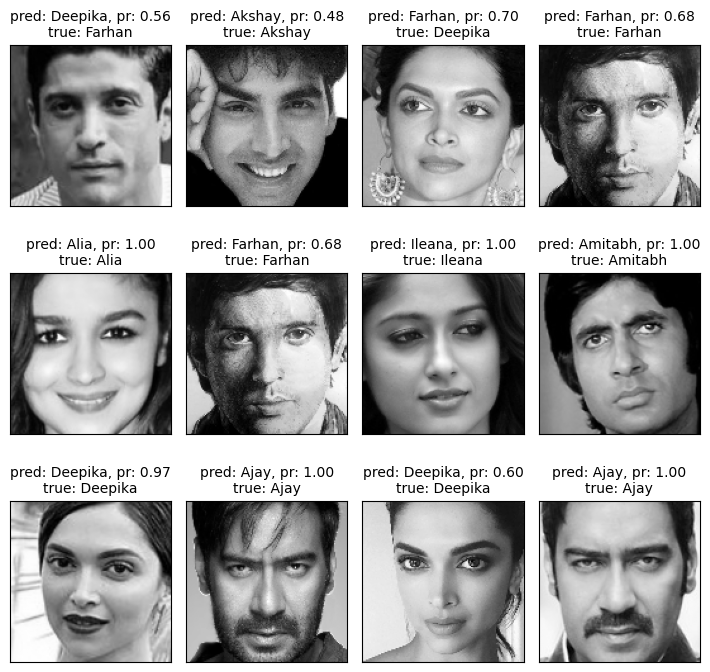

In [7]:
# compute probabilities and display top N test image
y_prob = clf.predict_proba(X_test_lda)
preds = np.argmax(y_prob, axis=1)
confidences = np.max(y_prob, axis=1)

prediction_titles = []
for i in range(len(preds)):
    true_name = class_names[y_test[i]]
    pred_name = class_names[preds[i]]
    pr = confidences[i]
    title = f'pred: {pred_name}, pr: {pr:.2f}\ntrue: {true_name}'
    prediction_titles.append(title)

test_images = X_test.reshape((-1, H, W))

# show first 12 test images
N = min(12, test_images.shape[0])
plot_gallery(test_images[:N], prediction_titles[:N], H, W, n_row=3, n_col=4)
